# Deep CNN for computer vision

In [1]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from utils import show_images

import numpy as np

# autoreload ALL modules in real time
%load_ext autoreload
%autoreload 2

In [2]:
# Your imports

num_workers = 2     # maximum number of subprocces (check https://pytorch.org/docs/stable/data.html for more info)
batch_size = 16     # increase or decrease batch_size here


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {} device'.format(device))

Using cuda device


# Task #1: Basic Pipeline [3 points]

## Step 1: Data Preparation

### Load [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) from torchvision.datasets

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# download data
train_data = torchvision.datasets.CIFAR10(
    root='/data/fmerin', train=True, download=True, 
    transform=transform
)

test_data = torchvision.datasets.CIFAR10(
    root='/data/fmerin', train=False, download=True, 
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
!ls /data/fmerin -lh

total 163M
drwxrwxr-x 3 fmerin fmerin 4.0K Mar 10 10:38 FashionMNIST
drwxr-xr-x 2 fmerin fmerin 4.0K Jun  4  2009 cifar-10-batches-py
-rw-rw-r-- 1 fmerin fmerin 163M Mar 10 09:25 cifar-10-python.tar.gz
drwxrwxr-x 6 fmerin fmerin 4.0K Mar 10 13:24 final


### Create dataloaders and plot some examples

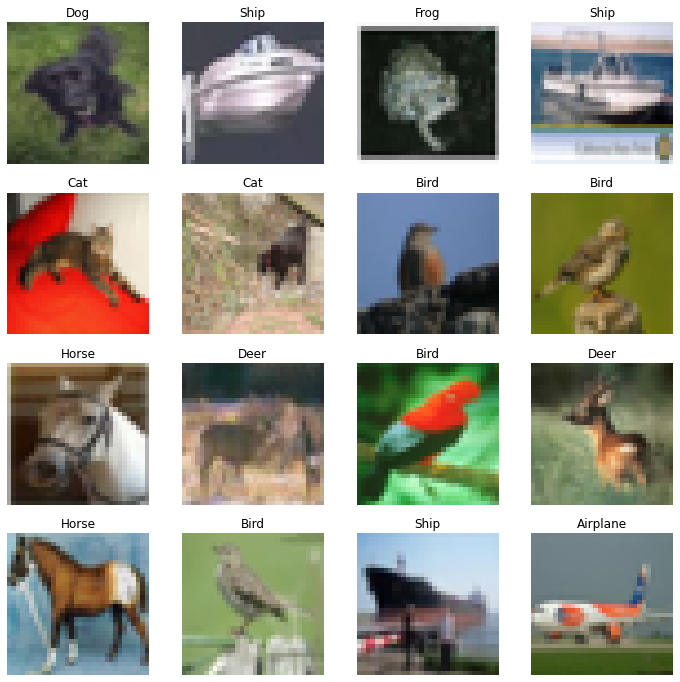

In [5]:
# create dataloaders for model
train_dataloader = torch.utils.data.DataLoader(
    train_data, shuffle=True, 
    batch_size=batch_size, num_workers=num_workers
)

test_dataloader = torch.utils.data.DataLoader(
    test_data, shuffle=True, 
    batch_size=batch_size, num_workers=num_workers
)

# show some images from CIFAR
labels_map = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck",
}

N_samples = 16
images, labels = next(iter(train_dataloader))
show_images(
    images[:N_samples], 
    [labels_map[i.item()] for i in labels[:N_samples]], 
    transform=transforms.ToPILImage()
)

**Hint!**

Use can use ```torchvision.utils.make_grid()``` for your own plots. Check [documentation](https://pytorch.org/vision/stable/utils.html) for examples.


## Step 2: Neural Network [1 point]


В этом задании вам предстоит заполнить пробелы в типичном pipeline для обучения нейросетей на pytorch. 

Для наглядности (и последующего сравнения с Deep CNN-сетями) будем использовать простейший перцептрон в качестве модели. 

**Hint!** Можно изменить размеры и число скрытых слоёв, передав в качестве аргумента ```blocks``` их список.

### NN Architecrute

In [28]:
from models import MLP

net = MLP(images[0].shape, n_classes=len(labels_map), blocks=[64, 32, 10]).to(device)

**Hint!** Можно обратиться к документации [pytorch](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) для примеров реализации функций ```train_loop()``` и ```test_loop()```.

### [1 point ] Train-test loops

In [8]:
import IPython
from math import ceil


def train_loop(model, dataloader, loss_fn, optimizer, step=0.05):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)

    size = len(dataloader.dataset)
    len_size = len(str(size))
    batches = ceil(size / dataloader.batch_size) - 1
    loss_log, acc_log = [], []
    
    percentage = 0
    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
        X, y = X.to(device), y.to(device)

        # evaluate
        # <----- your code here ----->
        output = model(X)
        loss = loss_fn(output, y)    
        
        # backpropagation
        # <----- your code here ----->
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # metrics
        loss_log.append(loss.item())
        acc = (output.argmax(1) == y).type(torch.float).sum() / y.shape[0]
        acc_log.append(acc.item())
        
        # print info
        if batch / batches > percentage or batch == batches: 
            out.update(f'[{int(percentage * size)}/{size}] Loss: {loss:>8f}')
            percentage += step
    
    history = {'train_acc': acc_log, 
               'train_loss': loss_log}
    return history
        
        
def test_loop(model, dataloader, loss_fn):

    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    batches = ceil(size / dataloader.batch_size)
    loss_log, acc_log = [], []

    with torch.no_grad():
        # evalute and check predictions
        # <----- your code here ----->
        for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
            X, y = X.to(device), y.to(device)
            output = model(X)
            
            loss = loss_fn(output, y).item()
            loss_log.append(loss)
            test_loss += loss
            
            correct_preds = (output.argmax(1) == y).type(torch.float).sum()
            acc = correct_preds / y.shape[0]
            acc_log.append(acc.item())
            correct += correct_preds.item()

    test_loss /= batches
    correct /= size
    
    print(f"Validation accuracy: {(100*correct):>0.1f}%, Validation loss: {test_loss:>8f} \n")
    
    history = {'val_acc': acc_log, 
               'val_loss': loss_log}
    return history

### [1 point] Learning curves

1. Модифицируйте функции ```train_loop()``` и ```test_loop()``` таким образом, чтобы они возвращали словарь ```history```, содержащий ключи ```val_acc```, ```val_loss```, ```train_acc``` и ```train_loss```. 

2. Постройте графики зависимости ```loss_fn``` и ```accuracy``` для обучающей и тестовой выборок от эпохи обучения.

**Hint!** Не стоит пропускать этот пункт: другие задания могут требовать наличия соответствующих графиков.

In [31]:
# <----- your code here ----->

# п.1 добавил в train/test loop выше
# п.2 отрисовал ниже

def plot_history(train_history, val_history, epochs, title):
    plt.figure()

    plt.title('{} at {} epochs'.format(title, epochs))
    plt.plot(train_history, label='train', zorder=1)
    plt.plot(val_history, '--', label='val', zorder=1)

    plt.xticks(range(0, epochs, 2), [x+1 for x in range(epochs)][::2])

    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

## Step 3: Train Network

**Hint!** В качестве лосс-функции следует использовать ```CrossEntropy```, а в качестве оптимизитора - ```Adam```.

In [29]:
%%time
# loss_fn, optimizer and number of epochs are required
# <----- your code here ----->
train_log, train_acc_log = [], []
val_log, val_acc_log = [], []

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), 1e-5)

epochs = 40
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_hist = train_loop(net, train_dataloader, loss_fn, optimizer)
    val_hist = test_loop(net, test_dataloader, loss_fn)
    
    train_log.append(np.mean(train_hist['train_loss']))
    train_acc_log.append(np.mean(train_hist['train_acc']))
    val_log.append(np.mean(val_hist['val_loss']))
    val_acc_log.append(np.mean(val_hist['val_acc']))
    
print("Done!")

Epoch 1
-------------------------------


'[50000/50000] Loss: 2.269121'

Validation accuracy: 19.6%, Validation loss: 2.220612 

Epoch 2
-------------------------------


'[50000/50000] Loss: 2.118160'

Validation accuracy: 21.5%, Validation loss: 2.156579 

Epoch 3
-------------------------------


'[50000/50000] Loss: 2.183880'

Validation accuracy: 22.9%, Validation loss: 2.118828 

Epoch 4
-------------------------------


'[50000/50000] Loss: 2.166595'

Validation accuracy: 23.9%, Validation loss: 2.094609 

Epoch 5
-------------------------------


'[50000/50000] Loss: 2.214850'

Validation accuracy: 24.6%, Validation loss: 2.074684 

Epoch 6
-------------------------------


'[50000/50000] Loss: 2.248184'

Validation accuracy: 25.7%, Validation loss: 2.052829 

Epoch 7
-------------------------------


'[50000/50000] Loss: 1.913508'

Validation accuracy: 26.9%, Validation loss: 2.028632 

Epoch 8
-------------------------------


'[50000/50000] Loss: 2.202239'

Validation accuracy: 28.7%, Validation loss: 2.010004 

Epoch 9
-------------------------------


'[50000/50000] Loss: 2.157984'

Validation accuracy: 29.5%, Validation loss: 1.992788 

Epoch 10
-------------------------------


'[50000/50000] Loss: 2.035491'

Validation accuracy: 30.0%, Validation loss: 1.978876 

Epoch 11
-------------------------------


'[50000/50000] Loss: 2.077644'

Validation accuracy: 30.2%, Validation loss: 1.969629 

Epoch 12
-------------------------------


'[50000/50000] Loss: 1.746157'

Validation accuracy: 30.8%, Validation loss: 1.956245 

Epoch 13
-------------------------------


'[50000/50000] Loss: 2.154860'

Validation accuracy: 31.4%, Validation loss: 1.946467 

Epoch 14
-------------------------------


'[50000/50000] Loss: 1.918669'

Validation accuracy: 32.1%, Validation loss: 1.936487 

Epoch 15
-------------------------------


'[50000/50000] Loss: 2.065242'

Validation accuracy: 32.4%, Validation loss: 1.930063 

Epoch 16
-------------------------------


'[50000/50000] Loss: 1.556166'

Validation accuracy: 32.6%, Validation loss: 1.920722 

Epoch 17
-------------------------------


'[50000/50000] Loss: 2.224062'

Validation accuracy: 33.5%, Validation loss: 1.912849 

Epoch 18
-------------------------------


'[50000/50000] Loss: 1.403549'

Validation accuracy: 33.9%, Validation loss: 1.904938 

Epoch 19
-------------------------------


'[50000/50000] Loss: 2.306924'

Validation accuracy: 34.2%, Validation loss: 1.897324 

Epoch 20
-------------------------------


'[50000/50000] Loss: 1.808437'

Validation accuracy: 34.7%, Validation loss: 1.891610 

Epoch 21
-------------------------------


'[50000/50000] Loss: 2.008314'

Validation accuracy: 34.8%, Validation loss: 1.886271 

Epoch 22
-------------------------------


'[50000/50000] Loss: 1.794325'

Validation accuracy: 35.2%, Validation loss: 1.879987 

Epoch 23
-------------------------------


'[50000/50000] Loss: 1.862610'

Validation accuracy: 35.3%, Validation loss: 1.876052 

Epoch 24
-------------------------------


'[50000/50000] Loss: 1.971335'

Validation accuracy: 35.5%, Validation loss: 1.869798 

Epoch 25
-------------------------------


'[50000/50000] Loss: 1.484912'

Validation accuracy: 35.5%, Validation loss: 1.867020 

Epoch 26
-------------------------------


'[50000/50000] Loss: 2.199589'

Validation accuracy: 35.8%, Validation loss: 1.859812 

Epoch 27
-------------------------------


'[50000/50000] Loss: 1.562116'

Validation accuracy: 35.9%, Validation loss: 1.855175 

Epoch 28
-------------------------------


'[50000/50000] Loss: 1.824478'

Validation accuracy: 35.9%, Validation loss: 1.850029 

Epoch 29
-------------------------------


'[50000/50000] Loss: 2.062149'

Validation accuracy: 36.2%, Validation loss: 1.846223 

Epoch 30
-------------------------------


'[50000/50000] Loss: 1.734973'

Validation accuracy: 36.5%, Validation loss: 1.842733 

Epoch 31
-------------------------------


'[50000/50000] Loss: 1.894378'

Validation accuracy: 36.3%, Validation loss: 1.838546 

Epoch 32
-------------------------------


'[50000/50000] Loss: 1.505996'

Validation accuracy: 36.5%, Validation loss: 1.836139 

Epoch 33
-------------------------------


'[50000/50000] Loss: 1.896524'

Validation accuracy: 36.6%, Validation loss: 1.834697 

Epoch 34
-------------------------------


'[50000/50000] Loss: 2.214562'

Validation accuracy: 36.8%, Validation loss: 1.826895 

Epoch 35
-------------------------------


'[50000/50000] Loss: 2.199681'

Validation accuracy: 37.0%, Validation loss: 1.823479 

Epoch 36
-------------------------------


'[50000/50000] Loss: 1.658889'

Validation accuracy: 37.0%, Validation loss: 1.820912 

Epoch 37
-------------------------------


'[50000/50000] Loss: 1.944623'

Validation accuracy: 36.8%, Validation loss: 1.817391 

Epoch 38
-------------------------------


'[50000/50000] Loss: 1.487358'

Validation accuracy: 37.1%, Validation loss: 1.814488 

Epoch 39
-------------------------------


'[50000/50000] Loss: 2.112289'

Validation accuracy: 37.4%, Validation loss: 1.810799 

Epoch 40
-------------------------------


'[50000/50000] Loss: 1.801873'

Validation accuracy: 37.5%, Validation loss: 1.806050 

Done!
CPU times: user 8min 41s, sys: 58.4 s, total: 9min 40s
Wall time: 10min 19s


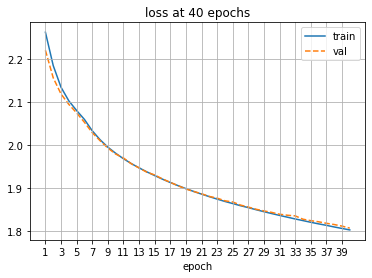

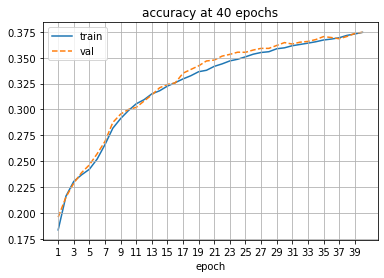

In [32]:
plot_history(train_log, val_log, epochs, title='loss')
plot_history(train_acc_log, val_acc_log, epochs, title='accuracy')

# Task #2: ResNet [4 points]

### [3 points: 1 for each correct class]

В этом задании от вас потребуется заполнить пропуски в ```./models/ResNet.py``` таким образом, чтобы полученная архитектура соответствовала ```resnet18```. Мы будем использовать именно эту модификацию архитектуры из-за её небольшого размера и относительной простоты самостоятельной реализации.

**Hint 0!**
В качестве примера можно опираться на соответствующую реализацию ```resnet18``` из **pytorch**.

**Hint 1!**
Благодаря **autoreload** вы можете использовать свежие изменения в ResNet.py без перезагрузки модуля. 

**Hint 2!**
Первым делом попробуйте сопоставить описанные классы с описанием встроенной в pytorch модели. Не забывайте про последовательную отладку.

In [33]:
# torchvision.models.resnet18() # uncomment this to see a Hint 0!

In [ ]:
from models import ResidualBlock, ResNetLayer, ResNet18

In [ ]:
# test ResidualBlock shapes
assert ResidualBlock(64, 64)(torch.rand(1, 64, 32, 32)).shape == torch.Size([1, 64, 32, 32])
assert ResidualBlock(64, 128)(torch.rand(1, 64, 32, 32)).shape == torch.Size([1, 128, 16, 16])
assert ResidualBlock(128, 256)(torch.rand(100, 128, 16, 16)).shape == torch.Size([100, 256, 8, 8])

In [ ]:
# test ResNetLayer shapes
assert ResNetLayer(64, 64)(torch.rand(1, 64, 32, 32)).shape == torch.Size([1, 64, 32, 32])
assert ResNetLayer(64, 128)(torch.rand(1, 64, 32, 32)).shape == torch.Size([1, 128, 16, 16])
assert ResNetLayer(128, 256)(torch.rand(100, 128, 16, 16)).shape == torch.Size([100, 256, 8, 8])

**Hint 3!**
Обратите внимание на структуру ```resnet18```. Первая часть (до появления ```ResNetLayer```) - это блок даунсэмплинга. Не забудьте модифицировать структуру сети так, чтобы она была применима к изображениям из **CIFAR10**. 

In [ ]:
dummy = ResNet18()(images) # эта строчка не должна вызывать ошибку

Обучите свою модель в течении небольшого количества эпох (6-30). 

In [ ]:
# loss_fn, optimizer and number of epochs are required
# <----- your code here ----->

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    # <----- your code here ----->

### [1 point]

Сравните процесс обучения свёрточной сети и перцептрона, а также число параметров. Какие выводы можно сделать?

<----- your answer here ----->

# Task #3: EfficientNet [3 points]

Иногда нет необходимости обучать модели "с нуля". Попробуем использовать для этой задачи технику, называющуюся **transfer learning**. В отличие от **fine tuning**, мы не будем переобучать всю сеть целиком. Вместо этого мы будем использовать уже предобученную сеть в качестве **fixed feature extractor**. 

Активации последнего свёрточного слоя мы будем использовать как уже готовые признаки. И уже на этих признаках мы обучим собственный классификатор, подходящий к нашей задаче.

Будем использовать обученную на датасете **ImageNet** сеть ```EfficientNet```. 

Чтобы адаптировать её к нашему датасету, потребуется **"заморозить" веса** и заменить классификатор модели. 

**Hint!** Обратитесь к документации [pytorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor) за подробностями. Обратите внимание, что мы **не переобучаем всю сеть целиком**.

## [1 point]

In [ ]:
from torchvision.models import efficientnet_b0


# load and freeze pretrained model
# <----- your code here ----->

# change classifier
# <----- your code here ----->

In [ ]:
# loss_fn, optimizer and number of epochs are required
# <----- your code here ----->

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    # <----- your code here ----->

## [2 points] Comparsion and tuning

Переобучите несколько (не меньше трёх различных) сетей из библиотеки ```torchvision.models```, используя **transfer learning**. Рекомендуется выбрать несколько вариаций одной и той же сети (например, ```resnet``` или ```efficientnet```). 

In [ ]:
# <----- your code here ----->

### [1 point]
Нарисуйте графики зависимости ошибки и точности во время обучения от числа прошедших эпох для всех сетей. 

**Hint 1!** На одном графике должны быть представлены все сети (а также легенда), но только один из четырёх параметров.

**Hint 1.5!** Из предыдущего пункта следует, что графиков должно быть... четыре.

**Hint 2!** Воспользуйтесь возможностью создавать ```subplot``` в библиотеке ```matplotlib```. 

In [ ]:
# <----- your code here ----->

 ### [1 point]
Сравните результаты. Как размер и глубина сети влияют на обучение?

<----- your answer here ----->

# Bonus Task #4: Deep Double Descent [5 points]

*Несмотря на то, что это задание является бонусным, крайне рекомендуется попробовать его осилить. Оно не настолько страшное, каким кажется со стороны, однако поможет закрепить полученные навыки.*

В этом задании вам предлагается познакомиться с эффектом, называемым [deep double descent](https://arxiv.org/abs/1912.02292). Ознакомительную краткую версию можно найти [тут](https://openai.com/blog/deep-double-descent/).


## 4.1 Network width impact [3 points]

Вы будете исследовать способность нейросети обобщать данные в зависимости от её архитектуры. Чтобы более ясно увидеть эту зависимость, потребуется добавить к обучающим данным некоторое количество шума. 

<img src="./resources/double_descent.png" width="700"/>

### 4.1.1 Adding noise

Необходимо подготовить три различных набора данных из уже доступного вам **CIFAR10**:

    1. В первом все метки классов правильные.
    2. Во втором 10% меток классов случайные.
    3. В третьем 20% меток классов случайные. 

### 4.1.2 Choose basic model

В качесте базовой модели будем использовать **ResNet18**. 

Вам потребуется изменять только количество каналов в каждом свёрточном слое (и, соответственно, размеры линейного слоя в классификаторе). На графике выше по оси абсцисс отмечена "ширина" сети, то есть число каналов входящих в сеть свёрток. Глубина сети, то есть число блоков или входных слоёв, должна остаться _неизменной_.

Начните с небольших свёрток по 4 нейрона на первом слое **ResNet18** и постепенно увеличивайте количество до 128-256 на первом слое. Число нейронов на последующих слоях должно меняться  пропорционально первому слою. Используйте разумный шаг при увеличении числа нейронов для построения графика.

Ваша задача - точно отследить, при каком количестве параметров сеть:

    a) Число параметров слишком мало, сеть не обладает обобщающей способностью.
    b) Число параметров оптимально или близко к оптимальному (первый локальный минимум на графике). 
    c) Число параметров больше, чем необходимо (с увеличением числа параметров значения loss-функции после обучения должны стремиться ко второму минимуму).

### 4.1.3 Compare models

Цель задания - самостоятельно получить такой же график, как и у авторов статьи. Однако в нашем случае мы хотим отрисовать три различных линии на графике: каждой линии должна соответстовать сеть, обученная на своей версии датасета из пункта **4.1.2**.

In [ ]:
# <----- your code here ----->

## 4.2 Network samples impact [2 points]

Это задание похоже на предыдущее: однако, в этом случае вы будем исследовать зависимость эффекта не от ширины сети, а от размера обучающей выборки. 

<img src="./resources/sample_wise_double_descent.svg" width="700"/>

### 4.2.1 Truncate dataset

Необходимо подготовить два различных набора данных из уже доступного вам **CIFAR10**:

    1. Полный датасет без изменений.
    2. 40% от датасета. 
    
### 4.2.2 Compare models


Аналогично **4.1**, глубина и топология сети должны оставаться неизменными; от вас снова требуется изменять только число нейронов в свёртках. Шаг и сетку параметров можно использовать такую же, как и пункте **4.1**.

Для каждого значения "ширины" сети требуется отметить две точки: значение **loss**-функции при обучении на полном датасете и на частичном. 


Так же как и в прошлом задании, вы можете опираться на результат авторов статьи (пример расположен выше). 

In [ ]:
# <----- your code here ----->